# Voyager LISM Scales EDA
1. Convergence study of correlation scales (parameters being the down-sampling cadence and the interval length)
1. Reproduction of Taylor and Correlation scales for one of the Fraternale intervals

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import datetime
import statsmodels.api as sm


# Add .. to the path
import sys
sys.path.append("..")

import src.utils as utils
from src.corr_funcs_claude import *


plt.rcParams.update({"font.size": 9})
plt.rc("text", usetex=True)

Text(0.5, 1.0, 'All Voyager 1 LISM data, weekly averages')

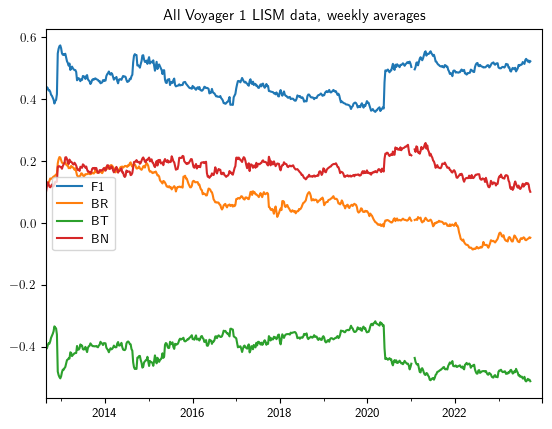

In [2]:
data_full = pd.read_pickle("../data/interim/voyager/voyager1_lism_cleaned.pkl")
data_full.resample("7D").mean().plot()
plt.title("All Voyager 1 LISM data, weekly averages")

We'll limit the data to one of the intervals studied by Fraternale 2019, 2021

In [3]:
# First, convert DOY to date
doy_to_date = lambda year, doy: datetime.datetime(year, 1, 1) + datetime.timedelta(
    doy - 1
)

# Set start date to start of Fraternale's interval I2 (312 days long)
# start_date = doy_to_date(2013, 131) # start of I1

# int_label = "I2"
# start_date = doy_to_date(2014, 184)
# end_date = doy_to_date(2015, 131)

# int_label = "I3"
# start_date = doy_to_date(2015, 220)
# end_date = doy_to_date(2016, 294)

# int_label = "I4"
# start_date  = doy_to_date(2017, 16)
# end_date = doy_to_date(2017, 272)

int_label = "I5"
start_date = doy_to_date(2018, 1)
end_date = doy_to_date(2018, 365)

data = data_full.loc[start_date:end_date]

data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 655201 entries, 2018-01-01 00:00:00 to 2018-12-31 00:00:00
Freq: 48s
Data columns (total 4 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   F1      135578 non-null  float32
 1   BR      135578 non-null  float32
 2   BT      135578 non-null  float32
 3   BN      135578 non-null  float32
dtypes: float32(4)
memory usage: 15.0 MB


## ACF re-sampling convergence study

Fraternale say how they resample to 288s (6-point averages), which apparently reduces noise, before calculating the ACF. Let's plot that now.

Text(0, 0.5, 'ACF')

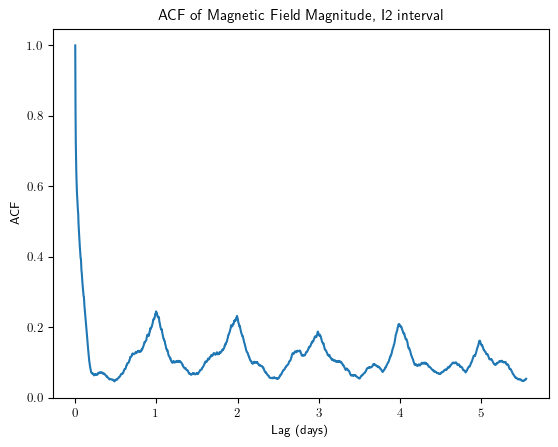

In [4]:
data_res = data.resample("288s").mean()
lags, acf = compute_nd_acf(
    time_series=[data_res["F1"]], nlags=int(10000/6), time_unit=TimeUnit.DAYS
)
plt.plot(lags, acf)
plt.title("ACF of Magnetic Field Magnitude, I2 interval")
plt.xlabel("Lag (days)")
plt.ylabel("ACF")

There are clear oscillations at multiples of about half a day, **the most important gap length in the data**. We can look into the effect of greater downsampling rates to see if the oscillations are still present

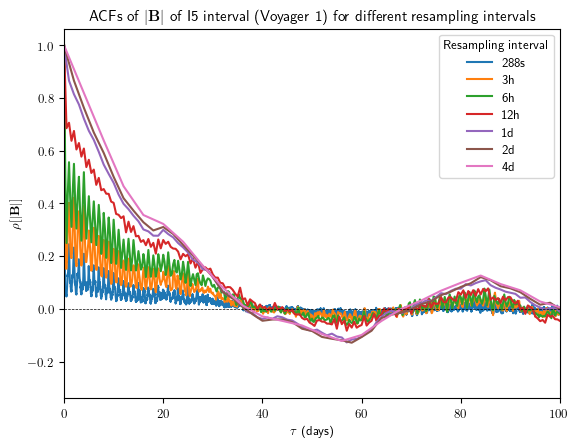

In [5]:
# Overlay ACFs from 3 different resamplings of data

for i, resampling in enumerate(["288s", "3h", "6h", "12h", "1d", "2d", "4d"]):
    data_res = data.resample(resampling).mean()
    lags, acf = compute_nd_acf(time_series=[data_res["F1"]], time_unit=TimeUnit.DAYS)
    plt.plot(lags, acf, label=resampling)
plt.xlabel("$\\tau$ (days)")
plt.ylabel("$\\rho[|\mathbf{B}|]$")
plt.legend(title="Resampling interval")
plt.title("ACFs of $|\mathbf{B}|$ of I5 interval (Voyager 1) for different resampling intervals")
plt.xlim(0,100)
plt.axhline(0, color="black", lw=0.5, ls="--")

### Attempted figure reproduction

We continue to have very high-frequency, gap-induced oscillations, until we get to daily averages, at which point we are averaging over the periodicity of the gaps, thereby removing these artefacts from the PSD. At greater amounts of downsampling, past 1d, the ACF changes little; it has "converged". 

Comparing the 288s version with Figue 3 from Fraternale et al. (2021), their I5 ACF (yellow line) looks similar.

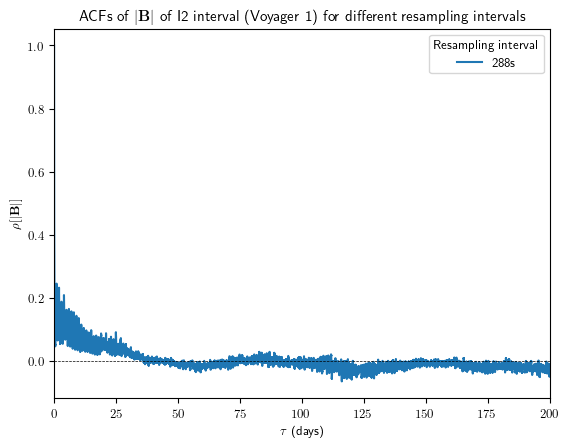  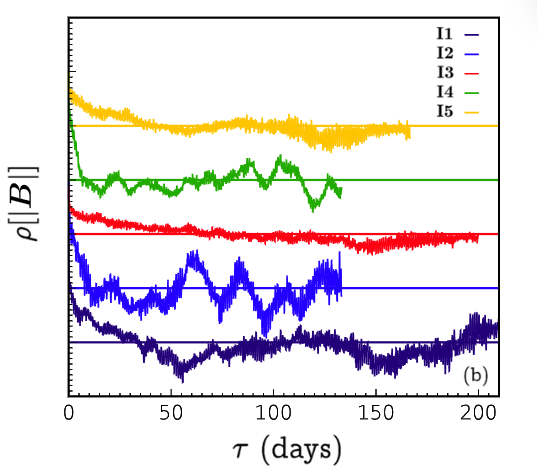

In [6]:
# Finalise resampling to 1D
data_res = data.resample("1d").mean()
data_res.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 365 entries, 2018-01-01 to 2018-12-31
Freq: D
Data columns (total 4 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   F1      358 non-null    float32
 1   BR      358 non-null    float32
 2   BT      358 non-null    float32
 3   BN      358 non-null    float32
dtypes: float32(4)
memory usage: 8.6 KB


### De-trending demo

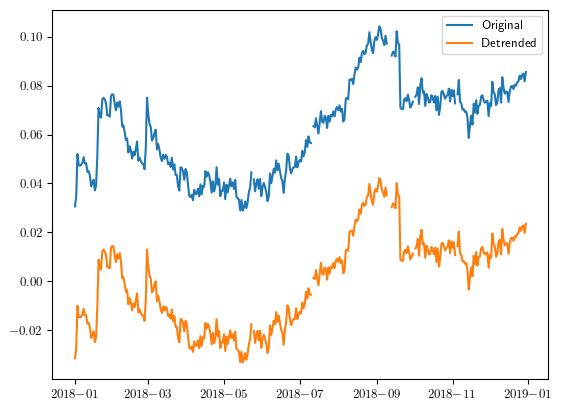

In [7]:
# Create function to remove linear trends from the data, allowing for NAs

def remove_trend(data, time_col, value_col):
    data = data.dropna(subset=[time_col, value_col])
    X = data[time_col].values
    y = data[value_col].values
    X = sm.add_constant(X)
    model = sm.OLS(y, X)
    results = model.fit()
    data["residuals"] = results.resid
    return data

data_res["BR_detrended"] = (
    data_res["BR"]
    - data_res["BR"].rolling(window=1000, center=True, min_periods=1).mean()
)

plt.plot(data_res["BR"], label="Original")
plt.plot(data_res["BR_detrended"], label="Detrended")
plt.legend()

^ Seems like a bad idea, as it is removing correlations. Won't be using this here. And while they did use this for plotting the ACFs in Fig. 3, they didn't actually use the ACFs for computing lambda C (though they did for lambda T)

## ACF interval-length convergence study

Using vector ACF of daily data, the correlation lengths plateaued at around
- I1: **14 days** (F21 value: 63.5 days)
- I2: **17 days** (F21: **19 days**)
- I5 (see below): does not plateau - grows up to about 40 days (F21 value: 60 days). *However, if using just the magnetic field component*, plateaus at about **14 days**)

In [8]:
# Getting all correlation scales and a combined plot in days

duration_days = np.arange(10, len(data_res), 10)
all_results = []

for duration_days in duration_days:
    end_date = start_date + datetime.timedelta(int(duration_days))
    interval = data_res[start_date:end_date]

    results = compute_all_correlation_scales(
        [interval.F1],
        time_unit=TimeUnit.DAYS,
        xmax=100, # days
        title=f"Correlation scale estimates from {duration_days} days of Voyager 1 data",
    )
    # Add duration to results
    results["interval_duration"] = duration_days


    all_results.append(results)

# # Combine all results into a dataframe
results_df = pd.DataFrame(all_results)

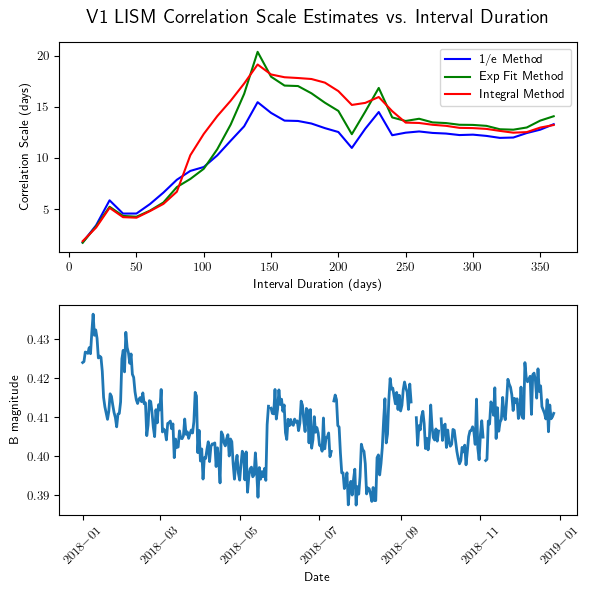

In [9]:
df = results_df

# Unique smoothing window values
# smoothing_windows = df["smoothing_window"].unique()

# Plot each method separately
methods = {
    "correlation_scale_1/e": "1/e Method",
    "correlation_scale_exp_fit": "Exp Fit Method",
    "correlation_scale_integral": "Integral Method",
}

colors = ['blue', 'green', 'red']

fig, axs = plt.subplots(2, 1, figsize=(6, 6))

# Plot correlation scale estimates
for method, label in methods.items():
    axs[0].plot(
        df["interval_duration"],
        df[method],
        color=colors[list(methods.keys()).index(method)],
        label=label,
    )

# axs[0].axvline(
#     312,
#     color="black",
#     linestyle="dotted",
#     alpha=0.5,
#     label="PSD Integral (Frat2021)",
# )
# axs[0].axhline(19, color="black", linestyle="dotted", alpha=0.5)
# axs[0].axhline(16, color="black", linestyle="--", label="'Best fit'=16 days")

axs[0].set_xlabel("Interval Duration (days)")
axs[0].set_ylabel("Correlation Scale (days)")
axs[0].set_title("V1 LISM Correlation Scale Estimates vs. Interval Duration", y=1.05, fontsize=14)

axs[0].legend()
# axs[0].set_ylim(0, 38)


# Plot interval
end_date = start_date + datetime.timedelta(400)
axs[1].plot(interval["F1"], lw=2)
axs[1].set_xlabel("Date")
axs[1].set_ylabel("B magnitude")
# Rotate x-axis labels
axs[1].tick_params(axis="x", rotation=45)


plt.tight_layout()
# plt.savefig(f"../results/cleaning/v1_lism_corr_scale_int_{int_label}.png", dpi=300)
plt.show()

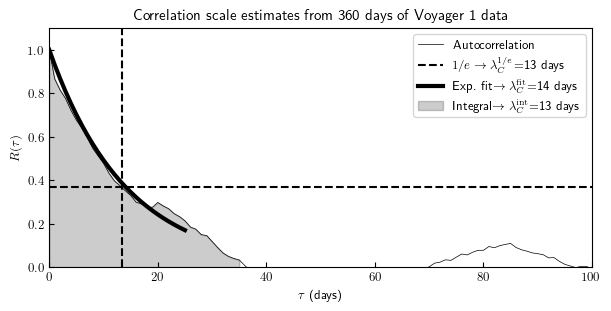

In [10]:
# Display the ACF figure for the full interval duration
results_df[results_df["interval_duration"] == 360]["figure_acf"].values[0]

**Using just the magnitude gives the most stable result for I5.** It also gave the closest results to the F21's 19 days for the I2 interval.

---

## Taylor scale

ACFS near the origin indeed Look like F21's Fig 3a inset - but not very parabolic!! We can fit Taylor scales using Richard extrapolation, and we will - but should we?

In [12]:
interval = data[start_date:end_date]

Text(0.5, 0, 'Lag (seconds)')

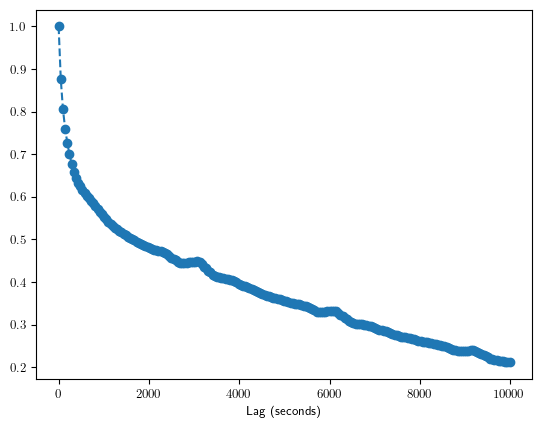

In [14]:
lags, acf = compute_nd_acf(
    time_series=[interval["F1"]], time_unit=TimeUnit.SECONDS, nlags=int(10000 / 48)
)
plt.plot(lags, acf, marker="o", linestyle="--")
plt.xlabel("Lag (seconds)")

c:\Users\spann\Documents\Research\Code repos\sf_gap_analysis\notebooks\..\src\utils.py:795: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "-y" (-> color='y'). The keyword argument will take precedence.
  ax[0].plot(


np.float64(0.06135193370951546)

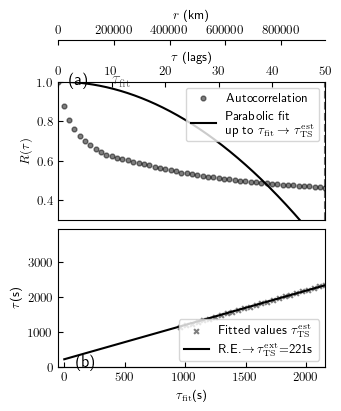

In [15]:
lambda_t, fig, ax = utils.compute_taylor_scale(
    lags, acf, tau_fit=50, plot=True, show_intercept=False, xlim=(0,50), ylim = (0.3,1)
)
ts_est_extra, ts_est_extra_std, fig, ax = utils.compute_taylor_chuychai(
    lags, acf, tau_min=20, tau_max=80, fig=fig, ax=ax
)
ts_est_extra / 3600
# Set show_intercept = True if you want piece of mind that the value returned is actually the x-intercept

This roughly matches the 0.063 hours from F21 - *but took a lot of toggling with fit ranges to get there*